In [1]:
# MOUNTING GOOGLE DRIVE

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# INSTALLING DEPENDENCY SUCH AS SPACY AND PRE-TRAINED WORD EMBEDDINGS

!pip install spacy
!python -m spacy download en_vectors_web_lg

✔ Download and installation successful
You can now load the model via spacy.load('en_vectors_web_lg')


In [3]:
# IMPORTING THE NECESSARY LIBRARIES

import tensorflow as tf
from tensorflow import keras
import numpy as np
import re
import spacy
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Embedding
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import os
import time
nlp = spacy.load('en_vectors_web_lg')

In [4]:
# IMPORTING THE DATASETS FROM THE MOUNTED DRIVE

lines = open("/content/gdrive/My Drive/chatbot_collab/movie_lines.txt", encoding='utf-8', errors='ignore').read().split("\n")
conversations = open("/content/gdrive/My Drive/chatbot_collab/movie_conversations.txt", encoding='utf-8', errors='ignore').read().split("\n")

In [6]:
# CREATING A DICT WHICH MAPS LINE ID TO LINE TEXT

id2line = {}
for line in lines:
    _line = line.split(" +++$+++ ")
    if len(_line) == 5:
        id2line[_line[0]] = _line[-1]

In [7]:
# CLEANSING OF TEXT IN ID2LINE VALUES

for i in id2line.keys():
    id2line[i] = id2line[i].lower()
    id2line[i] = str("<sos> ") + id2line[i].replace("i'm", "i am").replace("'s", " is").replace("'ll", " will").replace("'ve", " have").replace("'re", " are").replace("'d", " would").replace("won't", "will not").replace("can't", "can not").replace("n't", " not").replace("'", "") + str(" <eos>")

In [8]:
# CREATING LIST OF ALL THE CONVERSATIONS

conversations_ids = []
for conversation in conversations[:-1]:
    _conversation = conversation.split(" +++$+++ ")[-1][1:-1].replace("'","").replace(" ","")
    conversations_ids.append(_conversation.split(","))

In [9]:
# TOKENIZING AND EXTRACTING WORD_2_INDEX DICT

t = Tokenizer(num_words=18000, oov_token='<unk>', filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
t.fit_on_texts(id2line.values())
word_2_index_dict = t.word_index

In [10]:
# CREATING A REVERSE DICTIONARY FOR THE OUTPUTS

index_2_word_dict = {index : word  for word,index in word_2_index_dict.items()}

In [11]:
# CREATING NEW DICT FOR MATCHING ID TO ENCODED LINES 

encoded_lines = t.texts_to_sequences(id2line.values())
id_2_encoded_line = {}
k = 0
for i in id2line.keys():
    id_2_encoded_line[i] = encoded_lines[k]
    k += 1

In [12]:
# CREATING SEPARATELY THE QUESTION AND THE ANSWERS

questions = []
answers = []
for conversation in conversations_ids:
    for i in range(len(conversation) - 1):
        questions.append(id_2_encoded_line[conversation[i]])
        answers.append(id_2_encoded_line[conversation[i+1]])

In [13]:
# SETTING THE 80 PERCENTILE LENGTH OF QUESTIONS AND ANSWERS AS MAX QUES AND ANS LEN

len_of_all_questions = [len(ques) for ques in questions]
len_of_all_answers = [len(ans) for ans in answers]

max_ques_len = int(np.percentile(len_of_all_questions, 80))    #18
max_ans_len = int(np.percentile(len_of_all_answers, 90))       #27

In [14]:
# GETTING THE QUESTION AND ANSWERS SORTED

sorted_questions = []
sorted_answers = []
for i in range(3,max_ques_len + 1):
    for j,k in enumerate(questions):
        if i == len(k) and len(answers[j]) >= 3 and len(answers[j]) <= (max_ans_len):
            sorted_questions.append(k)
            sorted_answers.append(answers[j][1:])

In [15]:
# PADDING THE SORTED QUESTIONS AND ANSWERS

padded_sorted_ques = pad_sequences(sorted_questions, maxlen= max_ques_len, padding='pre')
padded_sorted_ans = pad_sequences(sorted_answers, maxlen= max_ans_len , padding='post',truncating='post')

In [16]:
# CREATING AN EMBEDDING MATRIX

max_tokens = 18000
embedding_matrix = np.random.randn(max_tokens, 300)
for i in range(1,max_tokens):
    if nlp.vocab[index_2_word_dict[i]].has_vector:
        embedding_matrix[i] = nlp.vocab[index_2_word_dict[i]].vector

In [17]:
# DEFINING THE PARAMETERS

epochs = 300
batch_size = 32
rnn_size = 1024
encoding_embedding_size = 300
decoding_embedding_size = 300
dropout_rate = 0.3
steps_per_epoch = len(sorted_questions)//batch_size

In [18]:
# DEFINING THE ENCODER CLASS OF MODEL

class Encoder(tf.keras.Model):
    def __init__(self, max_tokens, embedding_dim, enc_units, batch_sz, dropout_rate, embedding_matrix):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.dropout_rate = dropout_rate
        self.outputs = {}
        self.states = {}
        self.embedding = tf.keras.layers.Embedding(input_dim=max_tokens, output_dim= embedding_dim, weights = [embedding_matrix])
        self.lstmb1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.enc_units,
                                                                        return_sequences=True,
                                                                        return_state=True,
                                                                        dropout = self.dropout_rate,
                                                                        go_backwards=True), merge_mode='sum')
        
        self.lstmb2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.enc_units,
                                                                        return_sequences=True,
                                                                        return_state= True,
                                                                         dropout=self.dropout_rate, go_backwards=True), merge_mode='sum')
        
        self.lstmb3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.enc_units,
                                                                        return_sequences=True,
                                                                        return_state=True,
                                                                        dropout=self.dropout_rate, go_backwards=True), merge_mode='sum')

    
    def call(self, x):
        x = self.embedding(x)

        x, hf, hb, cf, cb = self.lstmb1(x)
        x, hf, hb, cf, cb = self.lstmb2(x, initial_state=[hf,hb,cf,cb])
        self.outputs, self.states["for_h"], self.states["for_c"], self.states["bac_h"], self.states["bac_c"] = self.lstmb3(x, initial_state=[hf,hb,cf,cb])
        return self.outputs, self.states


In [19]:
# DEFINING THE ATTENTION CLASS

class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    #query == states
    #values == output
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [20]:
# DEFINING THE DECODER CLASS OF MODEL

class Decoder(tf.keras.Model):
  def __init__(self, max_tokens, embedding_dim, dec_units, batch_sz, dropout_rate, embedding_matrix):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.dropout_rate = dropout_rate

    self.embedding = tf.keras.layers.Embedding(input_dim=max_tokens, output_dim= embedding_dim, weights = [embedding_matrix])
    self.lstm1 = tf.keras.layers.LSTM(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   dropout=self.dropout_rate)
    self.lstm2 = tf.keras.layers.LSTM(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   dropout=self.dropout_rate)
    self.lstm3 = tf.keras.layers.LSTM(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   dropout=self.dropout_rate)
    
    self.fc = tf.keras.layers.Dense(max_tokens)
    self.attention = BahdanauAttention(self.dec_units)
    

  def call(self, x, enc_output, hidden):
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    x, h, c = self.lstm1(x, initial_state = hidden)
    x, h ,c = self.lstm2(x, initial_state= [h, c])
    
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(h, enc_output)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # applying lstm
    x, h, c = self.lstm3(x, initial_state= [h, c])
    states = [h, c]

    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(x)

    return x, states,attention_weights


In [21]:
# CREATING THE DATASET
dataset = tf.data.Dataset.from_tensor_slices((padded_sorted_ques, padded_sorted_ans))
dataset = dataset.batch(batch_size, drop_remainder=True)

In [22]:
# CREATING OBJECTS OF MODEL CLASSES 
encoder = Encoder(max_tokens, encoding_embedding_size, rnn_size, batch_size, dropout_rate, embedding_matrix)
decoder = Decoder(max_tokens, decoding_embedding_size, rnn_size, batch_size, dropout_rate, embedding_matrix)

In [23]:
# DEFINING THE OPTIMIZER AND THE LOSS FUNCTION

optimizer = tf.keras.optimizers.Adam()

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = tf.keras.losses.sparse_categorical_crossentropy(y_true=real, y_pred=pred, from_logits=True)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [24]:
# DEFINING THE PARAMETERS AND FUNCTION FOR PLOTTING ACCURACY HISTORY DURING TRAINING

history={'loss':[]}
smallest_loss = np.inf
best_ep = 1

def plot_history():
    plt.figure(figsize=(7,7))
    plt.plot(best_ep,smallest_loss,'ro')
    plt.plot(history['loss'],'b-')
    plt.legend(['best','loss'])
    plt.show()

In [25]:
# DEFINING THE CHECKPOINT AND MANAGER FOR OBJECT BASED SAVING

checkpoint_dir = "/content/gdrive/My Drive/chatbot_collab/model_checkpoints"
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=1)

In [26]:
# THIS IS THE TRAIN STEP OF THE MODEL

def train_step(inp, targ):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_states = encoder(inp)

    dec_input = tf.expand_dims([word_2_index_dict['<sos>']] * batch_size, 1)
    dec_hidden = [ tf.add(enc_states["for_h"], enc_states["bac_h"]), tf.add(enc_states["for_c"], 
                                enc_states["bac_c"]) ]
    
    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden,_ = decoder(dec_input, enc_output, dec_hidden)

      loss += loss_function(targ[:, t], predictions)

      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [27]:
# IMPORTING LIBRARIES AND DEFINING FUNCTION FOR PREPROCESSING THE ASKED QUESTIONS

import unicodedata
import matplotlib.ticker as ticker

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

In [28]:
# FUNCTION FOR EVALUATING THE ANSWERS OF THE QUESTIONS ASKED (USED BY ANSWERING_QUES FUNCTION)

def evaluate(sentence, token):
  attention_plot = np.zeros((max_ans_len, max_ques_len))

  sentence = unicode_to_ascii(sentence.lower())
    
  inp = str("<sos> ") + sentence.replace("i'm", "i am").replace("'s", " is").replace("'ll", " will").replace("'ve", " have").replace("'re", " are").replace("'d", " would").replace("won't", "will not").replace("can't", "can not").replace("n't", " not").replace("'bout", "about").replace("'til", "until").replace("'", "") + str(" <eos>")
  inp = re.sub(r"[-()\"#/@;:{}`$+=~|.!?,]", "", inp)

  inp = token.texts_to_sequences([inp])[0]
  inp = pad_sequences([inp], maxlen=max_ques_len, padding='pre')
  inp = tf.convert_to_tensor(inp)

  result = ''

  enc_out, enc_states = encoder(inp)
  
  dec_hidden = [ tf.add(enc_states["for_h"], enc_states["bac_h"]), tf.add(enc_states["for_c"], 
                                enc_states["bac_c"]) ]
  dec_input = tf.expand_dims([word_2_index_dict['<sos>']], 1)

  for t in range(max_ans_len):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                           enc_out,
                                                          dec_hidden)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, [-1])
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    if index_2_word_dict[predicted_id] == '<eos>':
      return result, sentence, attention_plot

    result += index_2_word_dict[predicted_id] + ' '
    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [29]:
# FUNCTION FOR PLOTTING ATTENTION WEIGHTS DURING TRAINING

def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(5,5))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [30]:
# FUNCTION FOR ANSWERING THE QUESTION (USES EVALUATE FUNCTION)

def answering_ques(sentence, token, train):
  result, sentence, attention_plot = evaluate(sentence, token)
  
  print(result)

  if(train == 1):
    attention_plot = attention_plot[:len(result.split(' ')) - 1, :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Restored from /content/gdrive/My Drive/chatbot_collab/model_checkpoints/ckpt-43
Restoring after 43 checkpoint



Epoch 44 Batch 1 Loss 1.1638
Epoch 44 Batch 101 Loss 1.1286
Epoch 44 Batch 201 Loss 0.9856
Epoch 44 Batch 301 Loss 1.0477
Epoch 44 Batch 401 Loss 1.3305
Epoch 44 Batch 501 Loss 1.5170
Epoch 44 Batch 601 Loss 1.0939
Epoch 44 Batch 701 Loss 1.0416
Epoch 44 Batch 801 Loss 1.3773
Epoch 44 Batch 901 Loss 1.4200
Epoch 44 Batch 1001 Loss 1.0906
Epoch 44 Batch 1101 Loss 1.1158
Epoch 44 Batch 1201 Loss 1.3136
Epoch 44 Batch 1301 Loss 0.8552
Epoch 44 Batch 1401 Loss 0.9821
Epoch 44 Batch 1501 Loss 0.8629
Epoch 44 Batch 1601 Loss 1.4078
Epoch 44 Batch 1701 Loss 1.1612
Epoch 44 Batch 1801 Loss 0.8958
Epoch 44 Batch 1901 Loss 1.0757
Epoch 44 Batch 2001 Loss 0.8450
Epoch 44 Batch 2101 Loss 1.2383
Epoch 44 Batch 2201 Loss 1.3744
Epoch 44 Batch 2301 Loss 1.2473
Epoch 44 Batch 2401 Loss 1.2254
Epoch 44 Batch 2501 Loss 1.5169
Epoch 44 Batch 2601 Loss 0.9430
Epoch 44 Batch 2701 Loss 0.9537
Epo

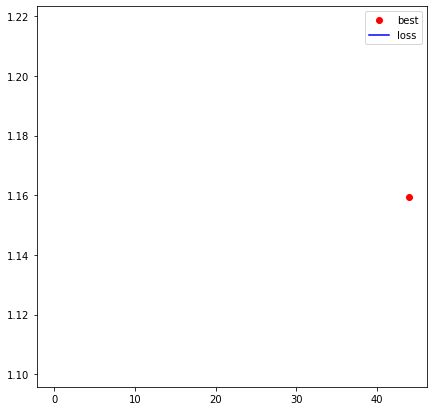

Epoch 44 Loss 1.1596
Time taken for 1 epoch 7506.9240345954895 sec
Best epoch so far:  44  smallest loss: tf.Tensor(1.1595545, shape=(), dtype=float32)
Checkpoint saved at: /content/gdrive/My Drive/chatbot_collab/model_checkpoints/ckpt-44



Ques:  Hello 
Ans :  is not a joke 


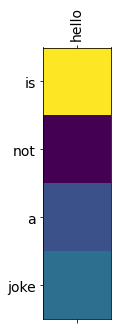

Ques:  how are you? 
Ans :  is not a joke 


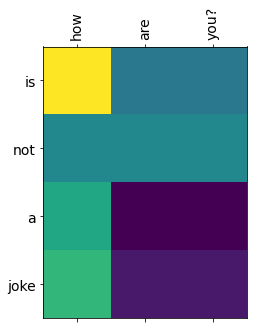

Ques:  What's up? 
Ans :  is not a joke 


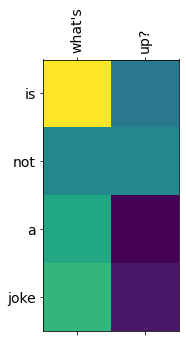

Ques:  What's your name? 
Ans :  is not a joke 


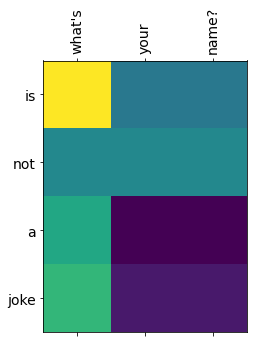

Ques:  I am tired. 
Ans :  is not a joke 


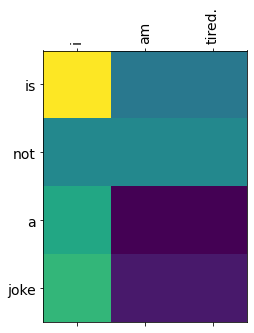

Ques:  You're so smart. 
Ans :  is not a joke 


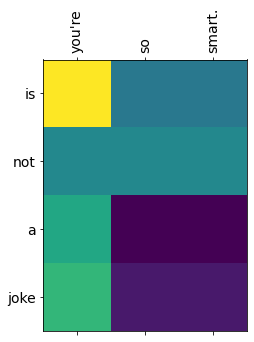





Epoch 45 Batch 1 Loss 1.1146
Epoch 45 Batch 101 Loss 1.1400
Epoch 45 Batch 201 Loss 0.9831
Epoch 45 Batch 301 Loss 1.0107
Epoch 45 Batch 401 Loss 1.2828
Epoch 45 Batch 501 Loss 1.4366
Epoch 45 Batch 601 Loss 1.0578
Epoch 45 Batch 701 Loss 1.0494
Epoch 45 Batch 801 Loss 1.3306
Epoch 45 Batch 901 Loss 1.3568
Epoch 45 Batch 1001 Loss 1.0690
Epoch 45 Batch 1101 Loss 1.0897
Epoch 45 Batch 1201 Loss 1.2967
Epoch 45 Batch 1301 Loss 0.8428
Epoch 45 Batch 1401 Loss 0.9395
Epoch 45 Batch 1501 Loss 0.8256
Epoch 45 Batch 1601 Loss 1.3814
Epoch 45 Batch 1701 Loss 1.1191
Epoch 45 Batch 1801 Loss 0.8853
Epoch 45 Batch 1901 Loss 1.0375
Epoch 45 Batch 2001 Loss 0.8426
Epoch 45 Batch 2101 Loss 1.1967
Epoch 45 Batch 2201 Loss 1.3494
Epoch 45 Batch 2301 Loss 1.2195
Epoch 45 Batch 2401 Loss 1.2011
Epoch 45 Batch 2501 Loss 1.4898
Epoch 45 Batch 2601 Loss 0.9228
Epoch 45 Batch 2701 Loss 0.9388
Epoch 45 Batch 2801 Loss 1.3315
Epoch 45 Batch 2901 Loss 1.2532
Epoch 45 Batch 3001 Loss 1.3754
Epoch 45 Batch 3

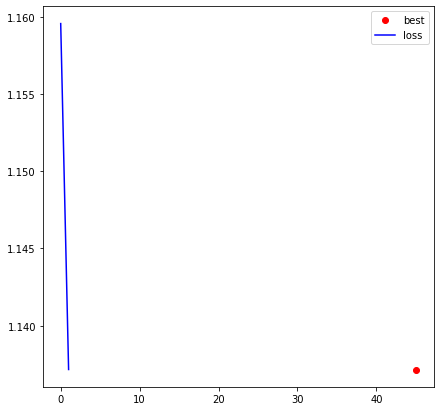

Epoch 45 Loss 1.1372
Time taken for 1 epoch 7691.095586299896 sec
Best epoch so far:  45  smallest loss: tf.Tensor(1.1371653, shape=(), dtype=float32)
Checkpoint saved at: /content/gdrive/My Drive/chatbot_collab/model_checkpoints/ckpt-45



Ques:  Hello 
Ans :  is not true 


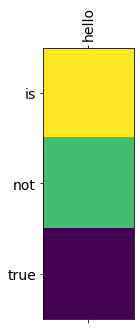

Ques:  how are you? 
Ans :  is not true 


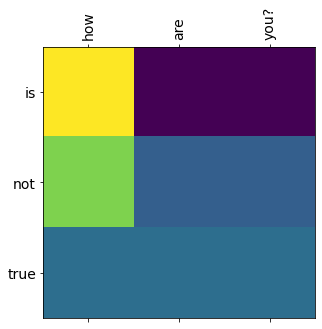

Ques:  What's up? 
Ans :  is not true 


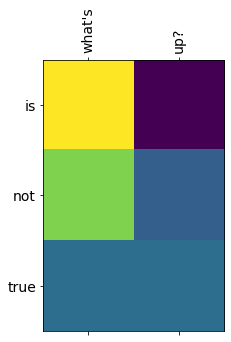

Ques:  What's your name? 
Ans :  is not true 


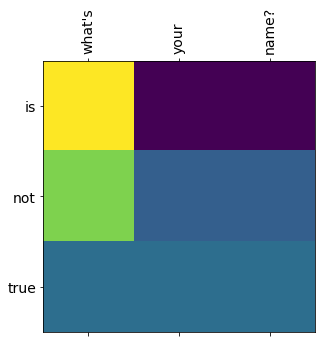

Ques:  I am tired. 
Ans :  is not true 


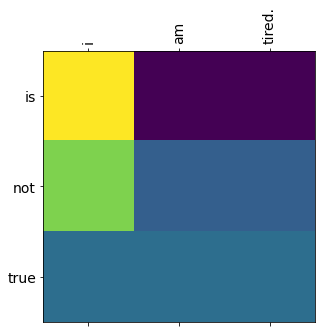

Ques:  You're so smart. 
Ans :  is not true 


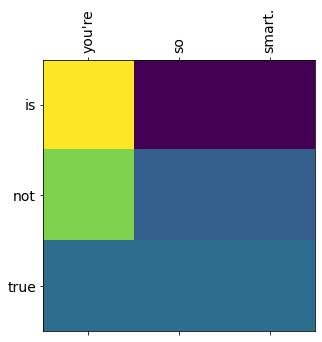





Epoch 46 Batch 1 Loss 1.1403
Epoch 46 Batch 101 Loss 1.1197
Epoch 46 Batch 201 Loss 0.9609
Epoch 46 Batch 301 Loss 1.0105
Epoch 46 Batch 401 Loss 1.2789
Epoch 46 Batch 501 Loss 1.4525
Epoch 46 Batch 601 Loss 1.0499
Epoch 46 Batch 701 Loss 1.0204
Epoch 46 Batch 801 Loss 1.3123
Epoch 46 Batch 901 Loss 1.3303
Epoch 46 Batch 1001 Loss 1.0723
Epoch 46 Batch 1101 Loss 1.0847
Epoch 46 Batch 1201 Loss 1.2806
Epoch 46 Batch 1301 Loss 0.8300
Epoch 46 Batch 1401 Loss 0.9352
Epoch 46 Batch 1501 Loss 0.8550
Epoch 46 Batch 1601 Loss 1.3861
Epoch 46 Batch 1701 Loss 1.0902
Epoch 46 Batch 1801 Loss 0.9124
Epoch 46 Batch 1901 Loss 1.0393
Epoch 46 Batch 2001 Loss 0.8375
Epoch 46 Batch 2101 Loss 1.1946
Epoch 46 Batch 2201 Loss 1.3109
Epoch 46 Batch 2301 Loss 1.2106
Epoch 46 Batch 2401 Loss 1.1802
Epoch 46 Batch 2501 Loss 1.4491
Epoch 46 Batch 2601 Loss 0.9152
Epoch 46 Batch 2701 Loss 0.9327
Epoch 46 Batch 2801 Loss 1.2814
Epoch 46 Batch 2901 Loss 1.2382
Epoch 46 Batch 3001 Loss 1.3669
Epoch 46 Batch 3

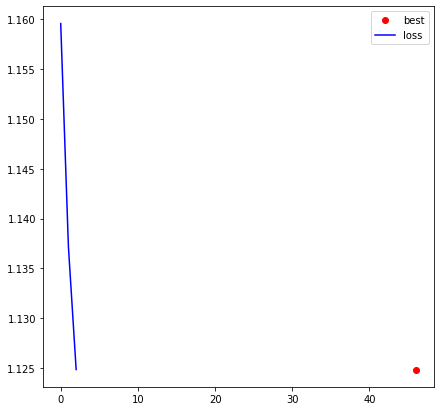

Epoch 46 Loss 1.1249
Time taken for 1 epoch 7679.612992763519 sec
Best epoch so far:  46  smallest loss: tf.Tensor(1.1248628, shape=(), dtype=float32)
Checkpoint saved at: /content/gdrive/My Drive/chatbot_collab/model_checkpoints/ckpt-46



Ques:  Hello 
Ans :  is the matter with you 


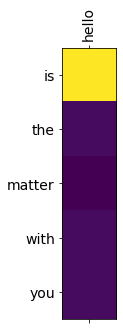

Ques:  how are you? 
Ans :  is the matter with you 


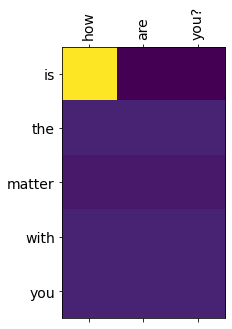

Ques:  What's up? 
Ans :  is the matter with you 


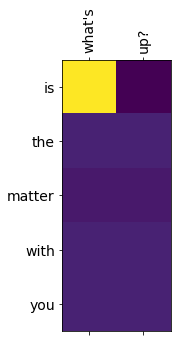

Ques:  What's your name? 
Ans :  is the matter with you 


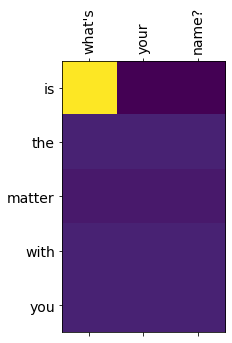

Ques:  I am tired. 
Ans :  is the matter with you 


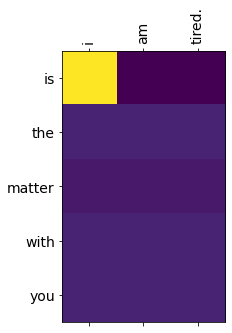

Ques:  You're so smart. 
Ans :  is the matter with you 


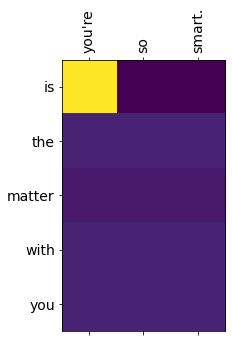





Epoch 47 Batch 1 Loss 1.1477


In [ ]:
# TRAINING STEP

ep = 1
checkpoint.restore(manager.latest_checkpoint)    # Restoring the Checkpoints
if manager.latest_checkpoint:
  print("Restored from {}".format(manager.latest_checkpoint))
  print("Restoring after {} checkpoint".format(manager.latest_checkpoint.split('-')[-1]))
  print("\n\n")
  ep = int(manager.latest_checkpoint.split('-')[-1]) + 1
                    
else:
  print("Initializing from scratch.")

for epoch in range(ep,epochs+1):
  start = time.time()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch,
                                                   batch + 1,
                                                   batch_loss.numpy()))
      
  
  epoch_loss = total_loss / steps_per_epoch
  history['loss'].append(epoch_loss)
  if epoch_loss < smallest_loss:
        smallest_loss = epoch_loss
        best_ep = epoch
        
  plot_history()
  save_path = manager.save()

  print('Epoch {} Loss {:.4f}'.format(epoch, total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec'.format(time.time() - start))
  print('Best epoch so far: ',best_ep,' smallest loss:',smallest_loss) 
  print("Checkpoint saved at: {}".format(save_path))
  print('\n\n')
  sents = ["Hello","how are you?","What's up?","What's your name?","I am tired.","You're so smart."]
  for s in sents:
    print('Ques: ',s,'\nAns :  ', end = '')
    answering_ques(s,t,1)
  
  print('\n\n\n')

In [35]:
# CHAT WITH THE BOT

checkpoint.restore(manager.latest_checkpoint)
while(True):
  print('Me  : ',end = '')
  ques = input()

  if(ques.lower() == 'bye'):
    print("Ans : Are you sure you want to QUIT? If YES enter 'y' Else press any other key _____")
    print("Me  : ",end = '')
    ans = input()
    
    if(ans.lower() == 'y'):
      print("Ans : Bye, Have a Nice Day...")
      break
    
    else:
      answering_ques(ques,t,0)
      print('\n')
      continue
  
  print('Ans : ', end = '')
  answering_ques(ques,t,0)
  print('\n')

Me  : hello...
Ans : is the matter with you 


Me  : yes, it matters with me
Ans : is the matter with you 


Me  : Shut up you fool... n just go to hell u rascal
Ans : is the matter with you 


Me  : bye
Ans : Are you sure you want to QUIT? If YES enter 'y' Else press any other key _____
Me  : y
Ans : Bye, Have a Nice Day...
